# Prashant

Output directory 'extracted' created.
Output visualization directory 'extracted/visualization' created.
Processing image: h2114153  h&e_ROI_5.tif
extracted/h2114153  h&e_ROI_5.tif Epithelia.png saved
extracted/h2114153  h&e_ROI_5.tif Stroma.png saved
extracted/visualization/h2114153  h&e_ROI_5.tif.png saved
Segmentation complete for single image.


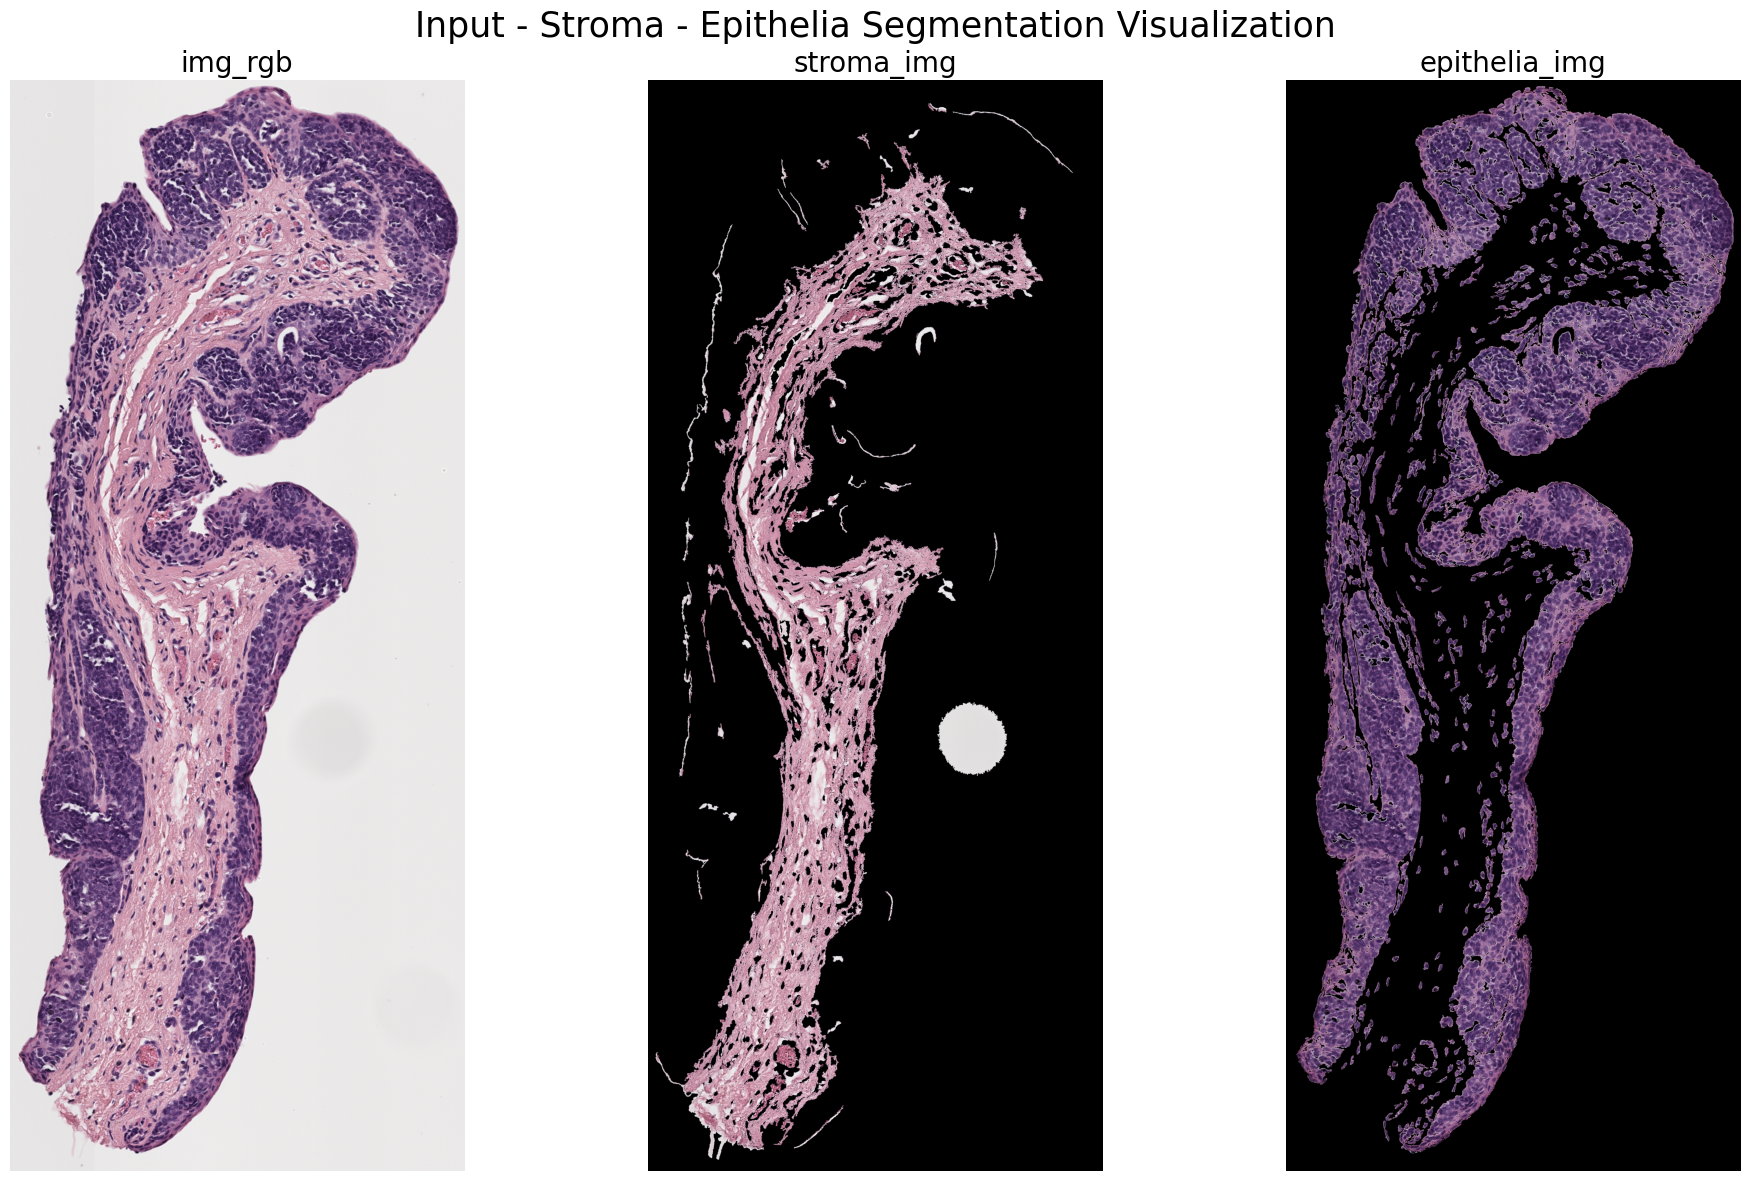

In [1]:
##########################################
##       SEGMENTATION ALGORITHM         ##
##########################################

show_images = 0                                 # to display images in real-time
save_intermediate_images = 0                    # save R-G-B and Y-Cb-Cr Channels
output_dir = "extracted"                        # epithelia and stroma will be saved here
overwrite_output = 0                            # to overwrite previous output
image_name = 'h2114153  h&e_ROI_5.tif'         # specific image to run with 'run_over_all_images = 0'
save_epithelia_and_stroma = 1                   # to save epithelia and stroma output

# Visualization settings
output_visualization_dir = "extracted/visualization"  # output for visual comparison
save_bins_representation = 0                    # to save Lumma and Red Chroma Bins for visualization

##########################################

import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import morphology
import gc

# Plot the image
def imshow(img, title):
    global show_images
    if show_images == 0:
        return

    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.title(title)
    plt.show(block=True)
    plt.close('all')

# Check and create necessary directories
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    print(f"Output directory '{output_dir}' created.")

if not os.path.isdir(output_visualization_dir):
    os.mkdir(output_visualization_dir)
    print(f"Output visualization directory '{output_visualization_dir}' created.")

# Process single image
input_filepath = image_name  # Set input filepath directly for a single image
if not os.path.isfile(input_filepath):
    print(f"File '{input_filepath}' does not exist! Exiting...")
    exit()

# Load Image
print(f"Processing image: {input_filepath}")
img_rgb = cv2.imread(input_filepath)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
imshow(img_rgb, 'img_rgb')

if save_bins_representation or show_images:
    fig = plt.figure(num=1, clear=True, figsize=(20, 12))
    ax_arr = fig.subplots(1, 4, sharex=True, sharey=True)
    fig.suptitle('RGB - R - G - B', fontsize=25)
    ax1, ax2, ax3, ax4 = ax_arr.ravel()
    ax1.imshow(img_rgb)
    ax1.set_title('RGB888', fontsize=20)
    ax1.set_axis_off()
    ax2.imshow(img_rgb[:, :, 0])
    ax2.set_title('Red Channel', fontsize=20)
    ax2.set_axis_off()
    ax3.imshow(img_rgb[:, :, 1])
    ax3.set_title('Green Channel', fontsize=20)
    ax3.set_axis_off()
    ax4.imshow(img_rgb[:, :, 2])
    ax4.set_title('Blue Channel', fontsize=20)
    ax4.set_axis_off()
    plt.tight_layout()
    if save_bins_representation:
        filename = os.path.join(output_visualization_dir, image_name + " RGB Channels.png")
        plt.savefig(filename)
        print(f"{filename} saved")

    if show_images:
        plt.show()

# Convert to YCrCb color space
img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)

# Define binning in lumma image
lumma_bins_n = 20
divisor = (np.floor(255 / lumma_bins_n)).astype(np.uint8)
lumma_binned = (np.floor(img_ycrcb[:, :, 0] / divisor)).astype(np.uint8)

if save_bins_representation:
    fig = plt.figure(num=1, clear=True, figsize=(20, 12))
    ax_arr = fig.subplots(2, int(lumma_bins_n / 2) + 1, sharex=True, sharey=True)
    fig.suptitle(image_name + " Lumma " + str(lumma_bins_n) + " Bins Representation", fontsize=25)
    row, col = 0, 0
    for bin_i in range(0, lumma_bins_n + 2):
        ax_arr[row, col].set_title("bin " + str(bin_i), fontsize=20)
        ax_arr[row, col].set_axis_off()
        ax_arr[row, col].imshow(lumma_binned == bin_i)
        col += 1
        if col == int(lumma_bins_n / 2) + 1:
            row += 1
            col = 0
    plt.tight_layout()
    filename = os.path.join(output_visualization_dir, image_name + " Lumma " + str(lumma_bins_n) + " Bins Representation.png")
    plt.savefig(filename)
    print(filename + " saved")
    if show_images:
        plt.show()

# Find background based on most populated lumma bin
most_pixels_bin = np.argmax(np.bincount(lumma_binned.ravel()))
background = lumma_binned == most_pixels_bin
background = morphology.remove_small_objects(background, 5000)
background = morphology.remove_small_holes(background, 10000)

if save_intermediate_images:
    filename = os.path.join(output_dir, image_name + " Lumma Background Mask.png")
    cv2.imwrite(filename, background.astype(np.uint8) * 255, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    print(f"{filename} saved")

# Red Chroma segmentation for stroma and epithelia
Cr_bins_n = 50
Cr_binned = (np.floor(img_ycrcb[:, :, 2] / (255 / Cr_bins_n))).astype(np.uint8)

# Find stroma using bins near most populated Cr bin
most_pixels_bin = np.argmax(np.bincount(Cr_binned.ravel()))
stroma_bin = most_pixels_bin
stroma = np.isin(Cr_binned, [stroma_bin, stroma_bin - 1, stroma_bin - 2])
stroma = stroma * np.invert(background)
stroma = morphology.dilation(stroma, morphology.square(3))
stroma = morphology.remove_small_objects(stroma, 1000)

# Find epithelia based on bins above the stroma bin
epithelia_bin = stroma_bin + 2
epithelia = np.isin(Cr_binned, [epithelia_bin, epithelia_bin + 1, epithelia_bin + 2, epithelia_bin + 3, epithelia_bin + 4])
epithelia = epithelia * np.invert(background)
epithelia = epithelia * np.invert(stroma)
epithelia = morphology.dilation(epithelia, morphology.square(2))
epithelia = morphology.remove_small_objects(epithelia, 500)

# Save segmentation results if enabled
if save_epithelia_and_stroma:
    epithelia_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(epithelia.astype(np.uint8) * 255))
    stroma_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(stroma.astype(np.uint8) * 255))
    filename = os.path.join(output_dir, image_name + " Epithelia.png")
    cv2.imwrite(filename, cv2.cvtColor(epithelia_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
    print(f"{filename} saved")
    filename = os.path.join(output_dir, image_name + " Stroma.png")
    cv2.imwrite(filename, cv2.cvtColor(stroma_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
    print(f"{filename} saved")

# Visualization of final segmentation
fig = plt.figure(num=1, clear=True, figsize=(20, 12))
ax_arr = fig.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle('Input - Stroma - Epithelia Segmentation Visualization', fontsize=25)
ax1, ax2, ax3 = ax_arr.ravel()
ax1.imshow(img_rgb)
ax1.set_title('img_rgb', fontsize=20)
ax1.set_axis_off()
ax2.imshow(stroma_img)
ax2.set_title('stroma_img', fontsize=20)
ax2.set_axis_off()
ax3.imshow(epithelia_img)
ax3.set_title('epithelia_img', fontsize=20)
ax3.set_axis_off()
plt.tight_layout()
filename = os.path.join(output_visualization_dir, image_name + ".png")
plt.savefig(filename)
print(f"{filename} saved")
if show_images:
    plt.show()

# Clean up memory
del img_rgb, img_ycrcb, stroma_img, epithelia_img, background, epithelia, stroma, Cr_binned, lumma_binned, filename
gc.collect()

print("Segmentation complete for single image.")


# Cross-View

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

# Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        backbone = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])  # Remove fully connected layers

    def forward(self, x):
        return self.feature_extractor(x)  # Output feature map

# Cross-View Transformer
class CrossViewTransformer(nn.Module):
    def __init__(self, feature_dim, num_heads, num_layers):
        super(CrossViewTransformer, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=feature_dim, nhead=num_heads, dim_feedforward=1024, activation='relu')
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self, query, key, value):
        for layer in self.layers:
            query = layer(query + key + value)
        return self.norm(query)

# Load Epithelium Mask and Calculate Full-Resolution Bounding Box
def calculate_full_resolution_epithelium_box(mask_path):
    mask_image = Image.open(mask_path).convert("L")  # Convert to grayscale
    np_mask = np.array(mask_image)
    binary_mask = np_mask > 0  # True where epithelium exists
    coords = np.argwhere(binary_mask)
    if coords.size == 0:
        raise ValueError("No epithelium detected in the mask.")
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return y_min, y_max, x_min, x_max

# Extract Full Color Patch within Epithelium Bounding Box
def extract_color_patch(original_image, epithelium_box, patch_size=(256, 256)):
    """
    Extract a full-color patch from the original image based on the epithelium box and patch size.
    """
    y_min, y_max, x_min, x_max = epithelium_box

    # Calculate center of the bounding box
    y_center = (y_min + y_max) // 2
    x_center = (x_min + x_max) // 2

    # Calculate patch coordinates, adjusting to fit within bounds if necessary
    x_start = max(0, x_center - patch_size[0] // 2)
    y_start = max(0, y_center - patch_size[1] // 2)
    x_end = min(original_image.width, x_start + patch_size[0])
    y_end = min(original_image.height, y_start + patch_size[1])

    # Extract the patch from the original image
    patch = original_image.crop((x_start, y_start, x_end, y_end))

    # Diagnostic: Log patch size and position
    print(f"Extracting patch from ({x_start}, {y_start}) to ({x_end}, {y_end})")

    return patch, (x_start, y_start, x_end, y_end)

# Draw Bounding Box on the Original Image
def draw_bounding_box(image, box_coords, color="blue", thickness=3):
    """
    Draw a bounding box on the given image.
    """
    draw = ImageDraw.Draw(image)
    x_start, y_start, x_end, y_end = box_coords
    for i in range(thickness):
        draw.rectangle([x_start - i, y_start - i, x_end + i, y_end + i], outline=color)

# Save Patch as Image
def save_patch_as_image(patch, output_folder, stain_name):
    os.makedirs(output_folder, exist_ok=True)
    patch.save(os.path.join(output_folder, f"{stain_name}_aligned_patch.png"))

# Preprocess Image for Feature Extraction
def preprocess_image(image_path, input_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), image  # Return both tensor and PIL image for visualization

# Main Pipeline with Saving Option
def process_images_with_epithelium(image_paths, mask_path, patch_size=(256, 256), output_folder="epithelium_patches"):
    # Preprocess images for feature extraction and alignment
    h_e_tensor, h_e_image = preprocess_image(image_paths[0])
    melana_tensor, melana_image = preprocess_image(image_paths[1])
    sox10_tensor, sox10_image = preprocess_image(image_paths[2])

    # Feature extraction step
    feature_extractor = FeatureExtractor()
    feature_dim = 2048  # Feature map channels from ResNet50
    cross_view_transformer = CrossViewTransformer(feature_dim=feature_dim, num_heads=8, num_layers=4)

    h_e_features = feature_extractor(h_e_tensor)
    melana_features = feature_extractor(melana_tensor)
    sox10_features = feature_extractor(sox10_tensor)

    # Calculate full-resolution bounding box for the epithelium region
    epithelium_box = calculate_full_resolution_epithelium_box(mask_path)
    print(f"Full-resolution epithelium bounding box: {epithelium_box}")

    # Align features using the cross-view transformer
    b, c, h, w = h_e_features.shape
    h_e_features_flat = h_e_features.flatten(2).permute(0, 2, 1)
    melana_features_flat = melana_features.flatten(2).permute(0, 2, 1)
    sox10_features_flat = sox10_features.flatten(2).permute(0, 2, 1)

    aligned_h_e_flat = cross_view_transformer(h_e_features_flat, melana_features_flat, sox10_features_flat)
    aligned_melana_flat = cross_view_transformer(melana_features_flat, h_e_features_flat, sox10_features_flat)
    aligned_sox10_flat = cross_view_transformer(sox10_features_flat, h_e_features_flat, melana_features_flat)

    aligned_h_e = aligned_h_e_flat.permute(0, 2, 1).reshape(b, c, h, w)
    aligned_melana = aligned_melana_flat.permute(0, 2, 1).reshape(b, c, h, w)
    aligned_sox10 = aligned_sox10_flat.permute(0, 2, 1).reshape(b, c, h, w)

    # Extract aligned patches directly from the original full-resolution images
    h_e_patch, h_e_box_coords = extract_color_patch(h_e_image, epithelium_box, patch_size)
    melana_patch, melana_box_coords = extract_color_patch(melana_image, epithelium_box, patch_size)
    sox10_patch, sox10_box_coords = extract_color_patch(sox10_image, epithelium_box, patch_size)

    # Draw bounding boxes on the original images
    draw_bounding_box(h_e_image, h_e_box_coords, color="red")
    draw_bounding_box(melana_image, melana_box_coords, color="red")
    draw_bounding_box(sox10_image, sox10_box_coords, color="red")

    # Save the annotated images showing where the patches were extracted from
    annotated_output_folder = os.path.join(output_folder, "annotated")
    os.makedirs(annotated_output_folder, exist_ok=True)
    h_e_image.save(os.path.join(annotated_output_folder, "H&E_with_bbox.png"))
    melana_image.save(os.path.join(annotated_output_folder, "Melana_with_bbox.png"))
    sox10_image.save(os.path.join(annotated_output_folder, "Sox10_with_bbox.png"))

    # Save the patches
    save_patch_as_image(h_e_patch, output_folder, "H&E")
    save_patch_as_image(melana_patch, output_folder, "Melana")
    save_patch_as_image(sox10_patch, output_folder, "Sox10")

    return h_e_patch, melana_patch, sox10_patch

# Run the Pipeline with Saving
if __name__ == "__main__":
    image_paths = [
        'h2114153 sox10_ROI_1.tif',
        'h2114153  melan_ROI_2.tif',
        'h2114153  h&e_ROI_5.tif',
    ]
    mask_path = 'extracted/h2114153  h&e_ROI_5.tif Epithelia.png'

    h_e_patch, melana_patch, sox10_patch = process_images_with_epithelium(image_paths, mask_path)
    print(f"Extracted aligned patches from epithelium region for each stain and saved them.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


Full-resolution epithelium bounding box: (32, 5737, 55, 2389)
Extracting patch from (1094, 2756) to (1350, 3012)
Extracting patch from (1094, 2756) to (1204, 2984)
Extracting patch from (1094, 2756) to (1350, 3012)
Extracted aligned patches from epithelium region for each stain and saved them.
